In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

##  Partie 1 : Echelle unique et inhibition

####  Calcul du Gradient avec un Noyau Gaussien

In [3]:
import numpy as np
from scipy.ndimage import convolve

def scale_dependent_gradient(image, sigma):
    # Fonction pour calculer le gradient à dépendance d'échelle
    # Création des noyaux gaussiens dérivés
    Gx, Gy = gaussian_derivative_kernels(sigma)
    
    # Convolution de l'image avec les noyaux dérivés
    F_sigma_x = convolve(image, Gx, mode='nearest')
    F_sigma_y = convolve(image, Gy, mode='nearest')
    
    # Calcul de la magnitude du gradient
    M_sigma = np.sqrt(F_sigma_x**2 + F_sigma_y**2)
    
    # Normalisation
    M_sigma /= np.max(M_sigma)
    
    return M_sigma

def gaussian_derivative_kernels(sigma):
    # Fonction pour créer les noyaux gaussiens dérivés
    # Taille du noyau (un multiple de sigma)
    sz = int(np.ceil(sigma * 3) * 2 + 1)
    
    # Création du noyau gaussien
    X, Y = np.meshgrid(np.arange(-sz/2, sz/2 + 1), np.arange(-sz/2, sz/2 + 1))
    G = np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    
    # Dérivées du noyau gaussien
    Gx = -X * G / sigma**2
    Gy = -Y * G / sigma**2
    
    return Gx, Gy


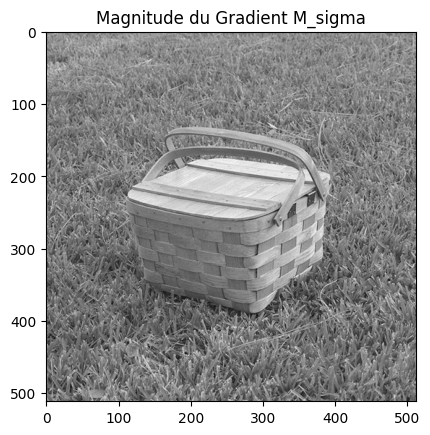

In [9]:
image = cv2.imread('database/images/basket.pgm', cv2.IMREAD_UNCHANGED)

if image is None:
    print("Error: Unable to read the image.")
else:
    # Continue with image processing
    image = image.astype(float)

# Afficher le gradient
plt.imshow(image, cmap='gray')
plt.title('Magnitude du Gradient M_sigma')
plt.show()

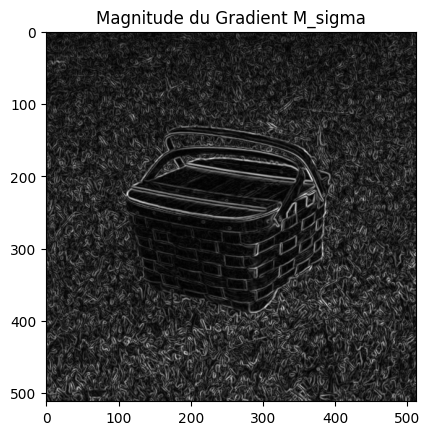

In [8]:
# Partie 1 : Echelle unique et inhibition
# Calcul du Gradient avec un Noyau Gaussien
# paramètre
sigma = 1

M_sigma = scale_dependent_gradient(image, sigma)

# Afficher le gradient
plt.imshow(M_sigma, cmap='gray')
plt.title('Magnitude du Gradient M_sigma')
plt.show()


#### Inhibition des Contours Environnants

In [10]:


def difference_of_gaussians(sigma):
    # Taille du noyau (un multiple de sigma)
    sz = int(np.ceil(sigma * 3) * 2 + 1)
    
    # Création de la grille de coordonnées
    X, Y = np.meshgrid(np.arange(-sz/2, sz/2 + 1), np.arange(-sz/2, sz/2 + 1))
    
    # Calcul des deux gaussiennes
    G1 = np.exp(-(X**2 + Y**2) / (2 * (sigma * 4)**2))
    G2 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    
    # Difference of Gaussians
    dog = np.maximum(G1 / (2 * np.pi * (sigma * 4)**2) - G2 / (2 * np.pi * sigma**2), 0)
    
    return dog

def normalization_term(sigma):
    # Calcul du DoG
    dog = difference_of_gaussians(sigma)
    
    # Calcul du terme de normalisation
    w_sigma = dog / np.sum(dog**2)
    
    return w_sigma

def suppression_term(M_sigma, sigma):
    # Calcul du DoG
    w_sigma = normalization_term(sigma)
    
    # Convolution du DoG avec la magnitude du gradient
    t_sigma = convolve(M_sigma, w_sigma, mode='nearest')
    
    return t_sigma

def contour_inhibition(M_sigma, sigma, alpha):
    # Calcul du terme de suppression
    t_sigma = suppression_term(M_sigma, sigma)
    
    # Supprimer les valeurs négatives
    t_sigma = np.maximum(t_sigma, 0)
    
    # Inhibition de contour
    c_sigma = M_sigma - alpha * t_sigma
    
    # Supprimer les valeurs négatives
    c_sigma = np.maximum(c_sigma, 0)
    
    return c_sigma


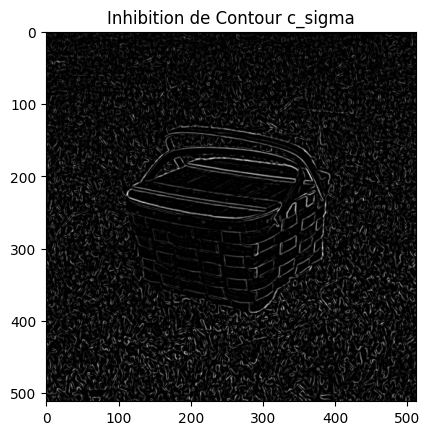

In [16]:
# paramètre
alpha = 0.005



c_sigma = contour_inhibition(M_sigma  , sigma , alpha)


# Afficher l'inhibition
plt.imshow(c_sigma, cmap='gray')
plt.title('Inhibition de Contour c_sigma')
plt.show()

#### Seuillage par hystérésie et suppression des non-maxima

In [17]:
from skimage import img_as_float

def find_neighbors(angle, i, j):
    # Détermination de la direction du gradient
    if (angle > -np.pi/8 and angle <= np.pi/8) or (angle > 7*np.pi/8 or angle <= -7*np.pi/8):
        neighb1 = (i, j-1); neighb2 = (i, j+1)
    elif (angle > np.pi/8 and angle <= 3*np.pi/8) or (angle > -7*np.pi/8 and angle <= -5*np.pi/8):
        neighb1 = (i-1, j-1); neighb2 = (i+1, j+1)
    elif (angle > 3*np.pi/8 and angle <= 5*np.pi/8) or (angle > -5*np.pi/8 and angle <= -3*np.pi/8):
        neighb1 = (i-1, j); neighb2 = (i+1, j)
    elif (angle > 5*np.pi/8 and angle <= 7*np.pi/8) or (angle > -3*np.pi/8 and angle <= -np.pi/8):
        neighb1 = (i-1, j+1); neighb2 = (i+1, j-1)
    return neighb1, neighb2

def supp_non_max(c_sigma):
    # Calcul du gradient
    Fx, Fy = np.gradient(img_as_float(c_sigma))
    angle = np.arctan2(Fy, Fx)
    
    # Suppression des non-maximas
    non_max_suppressed = np.zeros_like(c_sigma)
    for i in range(1, c_sigma.shape[0]-1):
        for j in range(1, c_sigma.shape[1]-1):
            # Trouver les voisins dans la direction du gradient
            neighb1, neighb2 = find_neighbors(angle[i, j], i, j)
            
            # Suppression des non-maxima
            if c_sigma[i, j] >= c_sigma[neighb1] and c_sigma[i, j] >= c_sigma[neighb2]:
                non_max_suppressed[i, j] = c_sigma[i, j]
    
    return non_max_suppressed

def seuil_hyst(c_sigma, seuil_bas, seuil_haut):
    # Suppression des non-maximas
    non_max_suppressed = supp_non_max(c_sigma)
    
    b_sigma = np.zeros_like(c_sigma)
    b_sigma[non_max_suppressed >= seuil_haut] = 1
    
    # Propagation des pixels forts aux faibles
    for i in range(1, c_sigma.shape[0]-1):
        for j in range(1, c_sigma.shape[1]-1):
            if non_max_suppressed[i, j] >= seuil_bas:
                if np.any(b_sigma[i-1:i+2, j-1:j+2] == 1):
                    b_sigma[i, j] = 1
    
    return b_sigma

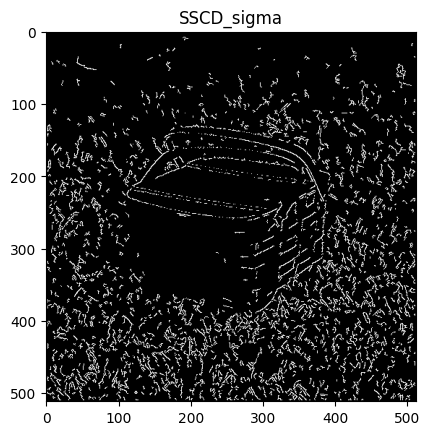

In [19]:
# Seuils à ajuster en fonction de l'image qu'on met en entrée
seuil_bas = 0.0000000000001
seuil_haut = 0.24


b_sigma = seuil_hyst(c_sigma, seuil_bas, seuil_haut)

# Afficher le résultat final
plt.imshow(b_sigma, cmap='gray')
plt.title('SSCD_sigma')
plt.show()

## Partie 2 : Echelle multiple et Canny

In [70]:
def dilat_morph(image):
    # Détection des Contours à l'Échelle Originale avec Canny
    edges = cv2.Canny(image.astype(np.uint8), 50, 150)
    
    # Opérateur DTO
    rows, cols = np.where(edges > 0)
    beta = np.zeros((image.shape[0] * 2, image.shape[1] * 2))
    beta[rows * 2, cols * 2] = 1
    
    # Dilatation morphologique
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))  # Use MORPH_ELLIPSE for a disk-shaped structuring element
    dto = cv2.dilate(beta.astype(np.uint8), se)
    
    return dto

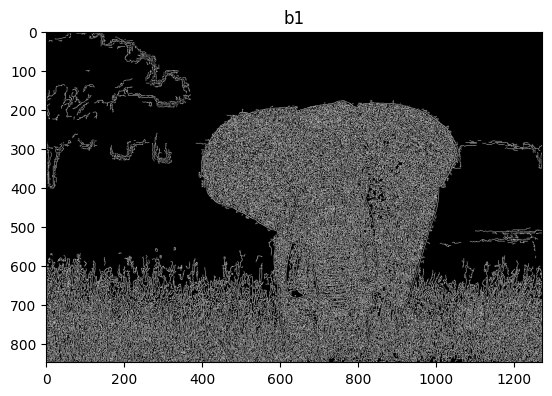

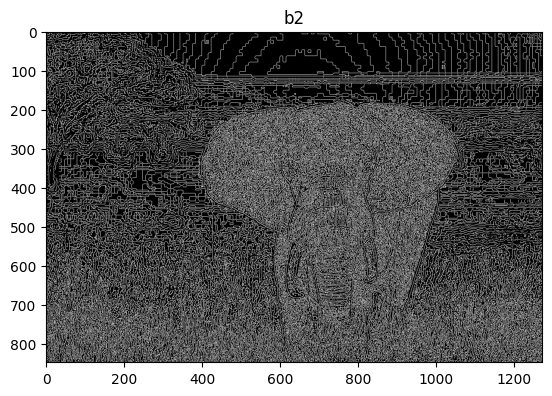

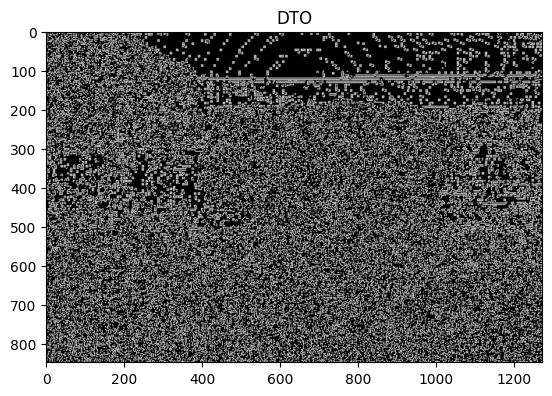

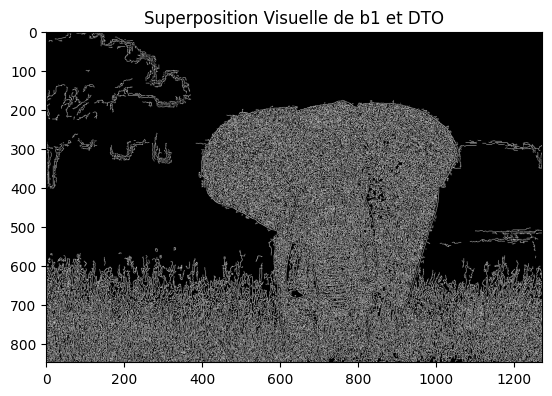

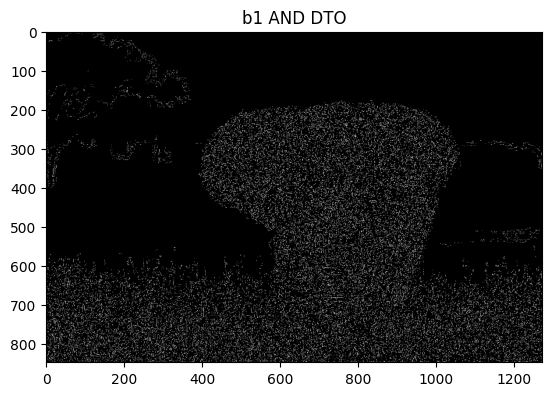

In [71]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Détection des Contours à l'Échelle Originale avec Canny sigma = 1 et 2
# Seuils à ajuster en fonction de l'image qu'on met en entrée
seuil_bas = 0.05
seuil_haut = 0.17

# Canny edge detection for sigma = 1
b1 = cv2.Canny(image.astype(np.uint8), int(seuil_bas * 255), int(seuil_haut * 255))
# Canny edge detection for sigma = 2
b2 = cv2.Canny(image.astype(np.uint8), int(seuil_bas * 255), int(seuil_haut * 255), apertureSize=5)

# Afficher les résultats
plt.imshow(b1, cmap='gray')
plt.title('b1')
plt.show()

plt.imshow(b2, cmap='gray')
plt.title('b2')
plt.show()

# Décimer b2
K = 2  # Facteur de décimation
b2 = b2[::K, ::K]


dto2 = dilat_morph(b2)

# Affichage du DTO
plt.imshow(dto2, cmap='gray')
plt.title('DTO')
plt.show()

# Ensure b1 and dto have the same dimensions
b1 = cv2.resize(b1, (dto2.shape[1], dto2.shape[0]))

# Convert b1 to the same data type as dto
b1 = b1.astype(np.uint8)

# Superposition visuelle de b1 et DTO
superposition_visuelle = cv2.addWeighted(b1, 0.5, dto2, 0.5, 0)

plt.imshow(superposition_visuelle, cmap='gray')
plt.title('Superposition Visuelle de b1 et DTO')
plt.show()

# Opération logique AND entre b1 et DTO
b1_and_dto = cv2.bitwise_and(b1, dto2)

plt.imshow(b1_and_dto, cmap='gray')
plt.title('b1 AND DTO')
plt.show()


##  Partie 3 : Echelle multiple et inhibition

In [72]:
def decim_im(image, N):
    sigma = 2**N
    sz = int(np.ceil(sigma * 3) * 2 + 1)
    X, Y = np.meshgrid(np.arange(-sz/2, sz/2 + 1), np.arange(-sz/2, sz/2 + 1))
    G = np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    im_convolu = convolve(image.astype(np.float32), G.astype(np.float32), mode='constant', cval=0.0)
    im_decimee = cv2.resize(im_convolu, None, fx=1/2**(N-1), fy=1/2**(N-1), interpolation=cv2.INTER_CUBIC).astype(np.float32)
    return im_decimee


def SingleScaleContourDetector(image):
    # Calcul du Gradient avec un Noyau Gaussien
    sigma = 1
    M_sigma = scale_dependent_gradient(image, sigma)
    
    # Inhibition des Contours Environnants
    alpha = 0.005
    c_sigma = contour_inhibition(M_sigma, sigma, alpha)
    
    # Seuillage hystérésique et suppression des non-maxima
    seuil_bas = 0.001
    seuil_haut = 0.1
    SSCD = seuil_hyst(c_sigma, seuil_bas, seuil_haut)
    
    return SSCD

In [73]:
# Paramètres
N = 3  # Nombre d'échelles

# Tableau de matrices et calcul des images à plusieurs échelles
images_decimees = [None] * N
images_decimees[0] = image

for n in range(2, N + 1):
    images_decimees[n-1] = decim_im(image,  n)

# Détection de contours à chaque échelle
contours_binaires = [None] * N

for n in range(N):
    contours_binaires[n] = SingleScaleContourDetector(images_decimees[n])

# Combine les contours à différentes échelles : de la plus grossière et en descendant progressivement
resultat_final = contours_binaires[N-1]

for n in range(N-2, -1, -1):
    # Dilatation du résultat actuel
    dto = dilat_morph(contours_binaires[n+1])
    
   

    # Combinaison avec la carte de contours à l'échelle suivante
    resultat_final = cv2.bitwise_and(contours_binaires[n], dto)

    plt.imshow(resultat_final, cmap='gray')
    plt.title('Résultat de la détection de contours multiscale avec inhibition du contour, étape : ' + str(n+1))
    plt.show()

plt.imshow(resultat_final, cmap='gray')
plt.title('Résultat de la détection de contours multiscale avec inhibition du contour')
plt.show()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:214: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'cv::binary_op'
